# ULTIMATE TECHNOLOGIES
## Data Science Challenge

# Part 1 ‑ Exploratory data analysis

The logins.json file contains (simulated) timestamps of user logins in a particular geographic location. 
- Aggregate these login counts based on 15 minute time intervals
- Visualize + describe the resulting time series of login counts (in ways that best characterize the underlying patterns of the demand)
- Report/illustrate important features of the demand, such as daily cycles. 
- If there are data quality issues, please report them.

### Import packages

In [1]:
import numpy as np
import pandas as pd
from numpy.random import seed
import matplotlib.pyplot as plt
import seaborn as sns

# set the style
plt.style.use('seaborn-whitegrid')

from datetime import timedelta

from scipy.stats import chi2_contingency
from scipy.stats import norm
from scipy.stats import t

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

# Managing warnings
import  warnings
warnings.simplefilter('ignore')


In [2]:
# timestamps of user logins in particular geo-location
df_logins = pd.read_json('data/logins.json')
df_logins

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21
...,...
93137,1970-04-13 18:50:19
93138,1970-04-13 18:43:56
93139,1970-04-13 18:54:02
93140,1970-04-13 18:57:38


In [3]:
print("min time: {}".format(df_logins.login_time.min()))
print("max time: {}".format(df_logins.login_time.max()))

min time: 1970-01-01 20:12:16
max time: 1970-04-13 18:57:38


- The time window is approximtaely 3 months. It starts in January, 1st of 1970 at 20:12:16 and it goes to April, 13th of 1970 at 18:57:38.

In [4]:
df_logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


- There are no missing values and the column is a datetime64 object.

In [5]:
# valid with DatetimeIndex, TimedeltaIndex or PeriodIndex for using resample()
df_logins = df_logins.set_index('login_time')

In [6]:
# aggregate login counts based on 15-minute time intervals
df_logins['count_15_min'] = 0
df_logins = df_logins.resample('15min').count()
df_logins.head()

,count_15_min
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


In [7]:
df_logins.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Freq: 15T
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   count_15_min  9788 non-null   int64
dtypes: int64(1)
memory usage: 152.9 KB


- There are 9788 rows and no missing values.

<AxesSubplot:title={'center':'Total logins seasonality'}, xlabel='login_time'>

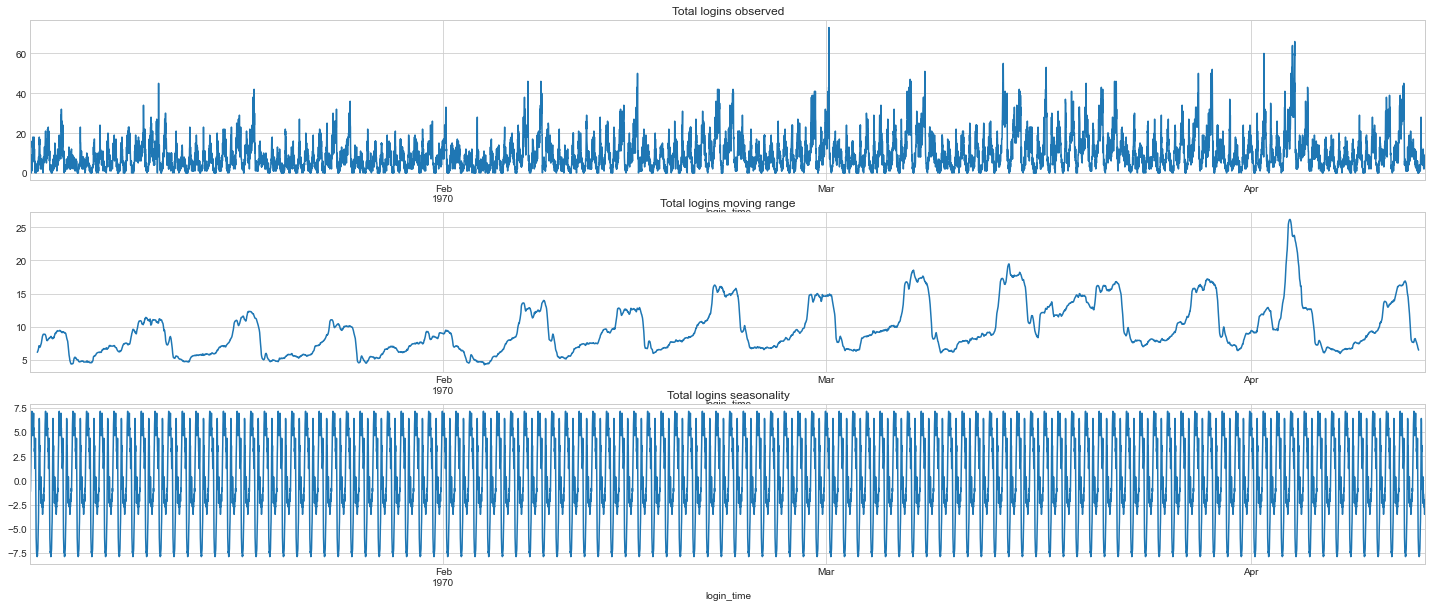

In [8]:
# Visualizing patterns 
from statsmodels.tsa.seasonal import seasonal_decompose

fig = plt.figure(figsize=(25,10)) 
season = seasonal_decompose(df_logins['count_15_min'], model='additive', freq=96)

plt.subplot(3, 1, 1)
plt.title('Total logins observed')
season.observed.plot()

plt.subplot(3, 1, 2)
plt.title('Total logins moving range')
season.trend.plot()

plt.subplot(3, 1, 3)
plt.title('Total logins seasonality')
season.seasonal.plot()

- There are patterns, although they are hard to interpret in the graphs above. Let's take a different look to better understand the data!

In [9]:
# reset index to perform feature engineering with timestamp column
df_logins = df_logins.reset_index()

In [10]:
# add weekday column
df_logins['weekday'] = df_logins['login_time'].dt.day_name()
df_logins.head()

,login_time,count_15_min,weekday
0,1970-01-01 20:00:00,2,Thursday
1,1970-01-01 20:15:00,6,Thursday
2,1970-01-01 20:30:00,9,Thursday
3,1970-01-01 20:45:00,7,Thursday
4,1970-01-01 21:00:00,1,Thursday


In [11]:
# groupby('key', as_index=False): key does not become index but a column (no need reset_index() later)
df_weekday = df_logins.groupby('weekday', as_index=False).sum()
df_weekday

,weekday,count_15_min
0,Friday,15208
1,Monday,8823
2,Saturday,19377
3,Sunday,18167
4,Thursday,11960
5,Tuesday,9268
6,Wednesday,10339


Text(0.5, 1.0, 'Logins By Day')

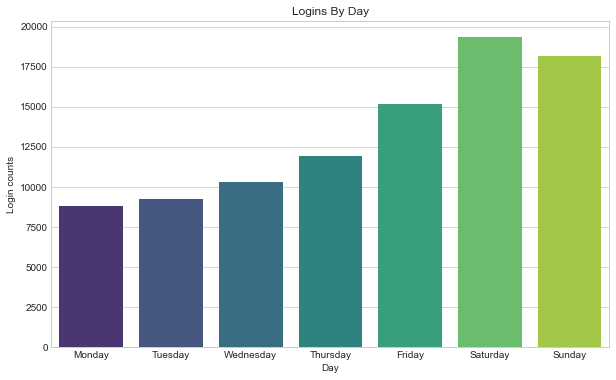

In [12]:
# let's graph this!
fig = plt.figure(figsize=(10,6)) 
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# bar plot
sns.barplot(x = 'weekday', y = 'count_15_min', 
            data = df_weekday, order=weekday_order,
           palette = "viridis")
plt.xlabel('Day')
plt.ylabel('Login counts')
plt.title('Logins By Day')


- The number of logins increase consistently from Monday to Saturday. It peaks on Saturday. There's a slight decrease in logins on Sunday compared to Saturday.
- Most logins take place on the weekend.

In [13]:
# add hour
df_logins['hour'] = df_logins['login_time'].dt.hour
df_logins.head()

,login_time,count_15_min,weekday,hour
0,1970-01-01 20:00:00,2,Thursday,20
1,1970-01-01 20:15:00,6,Thursday,20
2,1970-01-01 20:30:00,9,Thursday,20
3,1970-01-01 20:45:00,7,Thursday,20
4,1970-01-01 21:00:00,1,Thursday,21


Text(0.5, 1.0, 'Logins by Hour')

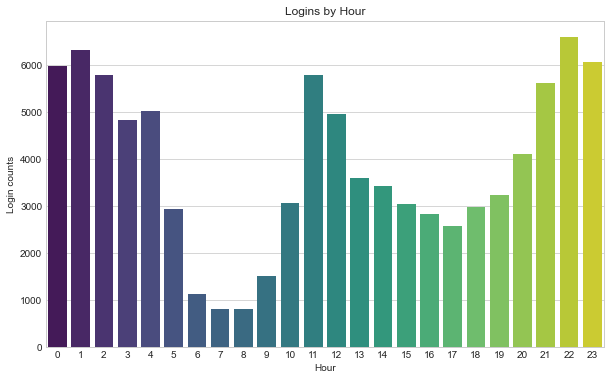

In [14]:
# Hourly graph
df_hour = df_logins.groupby('hour', as_index=False).sum()
fig = plt.figure(figsize=(10,6)) 

# bar plot
sns.barplot(x = 'hour', y = 'count_15_min', data = df_hour, palette = "viridis")
plt.xlabel('Hour')
plt.ylabel('Login counts')
plt.title('Logins by Hour')

- There are three peaks throughout the day:
    - 1 AM
    - 11 AM
    - 10 PM
- The highest number of logins take place from 9PM to 3AM.

In [15]:
# check the dataset
df_logins.head()

,login_time,count_15_min,weekday,hour
0,1970-01-01 20:00:00,2,Thursday,20
1,1970-01-01 20:15:00,6,Thursday,20
2,1970-01-01 20:30:00,9,Thursday,20
3,1970-01-01 20:45:00,7,Thursday,20
4,1970-01-01 21:00:00,1,Thursday,21


In [16]:
# create df with weekday and hour only for plot
df_day_hour = df_logins.groupby(['weekday','hour'], as_index=False).sum()
df_day_hour.head()

,weekday,hour,count_15_min
0,Friday,0,975
1,Friday,1,957
2,Friday,2,771
3,Friday,3,502
4,Friday,4,353


- Pandas: How to group-by and plot for each hour of each day of week
https://stackoverflow.com/questions/54856726/pandas-how-to-group-by-and-plot-for-each-hour-of-each-day-of-week

<Figure size 2016x1008 with 0 Axes>

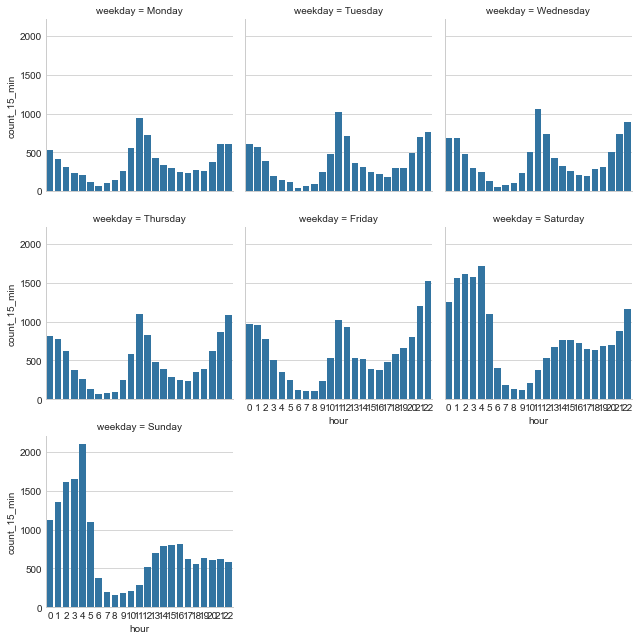

In [17]:
fig = plt.figure(figsize=(28,14))
g = sns.FacetGrid(df_day_hour, col="weekday", 
                  col_wrap=3, col_order=weekday_order)
g.map(sns.barplot, "hour", "count_15_min", order=range(0,23))

# Part 2 ‑ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. 

Please provide details on:
- a. how you will implement the experiment
- b. what statistical test(s) you will conduct to verify the significance of the
    observation
- c. how you would interpret the results and provide recommendations to the city
    operations team along with any caveats.
    
    
### Data description
- city: city this user signed up in
- phone: primary device for this user
- signup_date: date of account registration; in the form ‘YYYYMMDD’
- last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’
- avg_dist: the average distance in miles per trip taken in the first 30 days after signup
- avg_rating_by_driver: the rider’s average rating over all of their trips
- avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
- surge_pct: the percent of trips taken with surge multiplier > 1
- avg_surge: The average surge multiplier over all of this user’s trips
- trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
- ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
- weekday_pct: the percent of the user’s trips occurring during a weekday


# Part 3 ‑ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long­term rider retention (again, a few sentences will suffice).